# An example in high-dimension

We run our algorithm on the superconductivity dataset with polynomial features.

In [7]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['agg.path.chunksize'] = 10000
%matplotlib inline

### Data loading

In [8]:
# data loading -------------------
import pandas as pd
dataframe = pd.read_csv("data/superconductivity/train.csv") #,sep=',')
data = pd.DataFrame.as_matrix(dataframe)

/Users/boyer/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [9]:
print("The number of rows is ") 
print(data.shape[0])
print("The number of columns is ") 
print(data.shape[1])

The number of rows is 
21263
The number of columns is 
82


### Data preprocessing

In [10]:
# data preprocessing -------------------
X = data[:,0:81] # features in the first 81 columns
y = data[:,81] # target in the 82th column

from sklearn.preprocessing import scale
X = scale(X)
y = scale(y)
X_full = X
y_full = y


# subsample
n_subsample = 21262
X_test = X[n_subsample:, :]
y_test = y[n_subsample:]

X=X[:n_subsample, :]
y=y[:n_subsample]


n,d = X.shape

print("The number of samples is ") 
print(X.shape[0])
print("The number of variables is ") 
print(X.shape[1])

The number of samples is 
21262
The number of variables is 
81


In [11]:
# polynomial features -------------------
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True, order='C')
X_poly = poly.fit_transform(X)
X_test_poly = poly.fit_transform(X_test)
X_full_poly = poly.fit_transform(X_full)
print("The number of variables is now ") 
print(X_poly.shape[1])

The number of variables is now 
3403


In [12]:
X_poly[:10,0] # checking that the intercept is in the first column

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Introducing missing values

In [13]:
# Introducing MCAR missing values -------------------


# random seed for reproducibility
np.random.seed(42)

# Homogeneous MCAR
p=0.7
mask_init = np.random.binomial(n=1, p=p, size= (n,d))

# cleaning of individuals with only missing values
index = mask_init.sum(axis=1)!=0
X_poly = X_poly[index,]
y = y[index,]
mask_init = mask_init[index,]

# Mask for polynomial features 
mask_poly = poly.fit_transform(mask_init)
X_poly_NA = X_poly*mask_poly

In [14]:
print("Initial mask shape")
print(mask_init.shape)
print("Poly mask shape")
print(mask_poly.shape)

Initial mask shape
(21262, 81)
Poly mask shape
(21262, 3403)


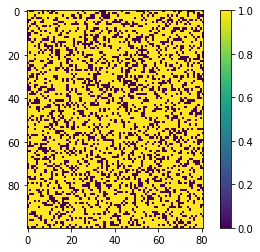

In [15]:
# plotting the first 100 rows of the initial mask
plt.imshow(mask_init[:100,:])
plt.colorbar()

Text(0.5,1,'Estimation of probability of presence for polynomial features')

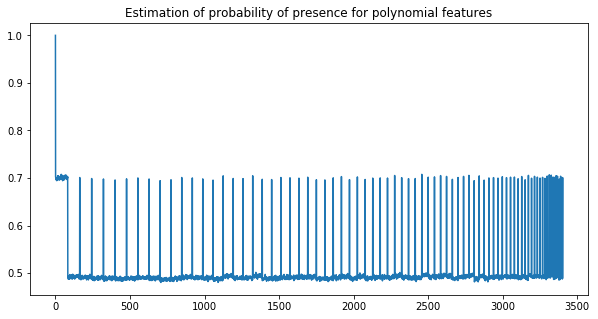

In [16]:
# with polynomial features => heterogeneous missing case

p_estim = np.sum(mask_poly,axis=0)/mask_poly.shape[0]
plt.figure(figsize=(10, 5))
plt.plot(p_estim)
plt.title('Estimation of probability of presence for polynomial features')

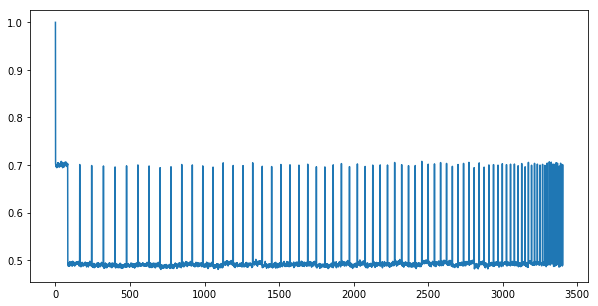

In [19]:
p_estim = np.sum(mask_poly,axis=0)/mask_poly.shape[0]
plt.figure(figsize=(10, 5))
plt.plot(p_estim)
plt.savefig('poly_feature_superconductivity_proba.pdf')

### X_poly is not full rank

In [195]:
#u,d,v = np.linalg.svd(X)

In [196]:
#u,d,v = np.linalg.svd(X_poly)
#min(d)

In [197]:
#u,d,v = np.linalg.svd(X_poly_NA)
#min(d)

X_poly is not full rank but X_poly_NA is

### Regression without missing values

In [11]:
# Regression from scikit without missing values ------------------
from sklearn.linear_model import LinearRegression
import time

regScikit = LinearRegression(fit_intercept = False)
start = time.time()
regScikit.fit(X_poly,y)
cpu_time_scikit = time.time() - start

beta_ref = regScikit.coef_
print("Linear regression with scikit took ", "%.2f" % cpu_time_scikit)

Linear regression with scikit took  29.48


In [12]:
# Regression from scikit without missing values ------------------
from sklearn.linear_model import Ridge
import time

regScikitRidge = Ridge(fit_intercept = False, alpha=0.001)
start = time.time()
regScikitRidge.fit(X_poly,y)
cpu_time_scikit = time.time() - start

beta_ref_ridge = regScikitRidge.coef_
print("Ridge regression with scikit took ", "%.2f" % cpu_time_scikit, 's')

Ridge regression with scikit took  5.74 s


#### Some checks on the train set

In [13]:
# checking some predictions on train 
(regScikit.predict(X_poly))[:10],y[0:10]

(array([-0.29884989, -0.31412936, -0.34866346, -0.31886402, -0.27472212,
        -0.22639772,  0.44164144, -0.21748145, -0.18226523, -0.15678701]),
 array([-0.15826733, -0.24584948, -0.45020782, -0.36262567, -0.33343162,
        -0.33343162, -0.68376021, -0.04149114,  0.04609101, -0.09987924]))

In [14]:
print('MSE with scikit linear predictor on train', "%.2e" % (np.linalg.norm((regScikit.predict(X_poly))-y)**2/n))
print('MSE with scikit ridge a=0.1      on train', "%.2e" % (np.linalg.norm((regScikitRidge.predict(X_poly))-y)**2/n))

MSE with scikit linear predictor on train 9.63e-02
MSE with scikit ridge a=0.1      on train 9.79e-02


## Ridge + cross validated error + optimal alpha

In [15]:
from sklearn.linear_model import RidgeCV

clf = RidgeCV(alphas=1/14**(np.arange(0, 8)), store_cv_values=True).fit(X_full_poly,y_full)
clf.score(X_full_poly,y_full), np.mean(clf.cv_values_, 0)

(0.882663005524248,
 array([0.14497404, 0.1732119 , 0.22291973, 0.24986177, 0.26806887,
        0.27330608, 0.27453375, 0.27465534]))

## SGD strategies for NA

In [16]:
from sgd_lin_na import *

In [18]:
nepoch = 1
step1 = 1e-5

In [19]:
np.random.seed(42)

beta0 = np.zeros(X_poly_NA.shape[1])
niter = X_poly_NA.shape[0]*nepoch

### with complete data

In [20]:
n,d = X_poly.shape
model = LinearRegressorNA_oracle(X_comp=X_poly,
                                 X=X_poly,
                                 D=mask_poly,
                                 y=y,
                                 p=1,
                                 beta_true=beta_ref,
                                 strength=0)
L = model.lip_max()

In [25]:
#Avg SGD - complete data -----------------------------------

#step1 = 1/(2*L)
callback_av_sgd_comp = inspector(model, verbose=False)
start = time.time()
beta_av_sgd_comp = avsgdNA(model, 
                           beta0 = beta0,
                           nepoch = nepoch, 
                           step = step1, 
                           callback = callback_av_sgd_comp)
cpu_time_av_sgd_comp = time.time() - start
print("Linear regression with av SGD  for complete data took")
print(cpu_time_av_sgd_comp)

Linear regression with av SGD  for complete data took
9.756678104400635


### with NA

In [26]:
# mean of the probabilities to be present => to test the homogeneous case
p_ave = np.mean(p_estim)
p_ave = p_ave*np.ones((d))

In [27]:
model_NA = LinearRegressorNA_oracle(X_comp=X_poly,
                                    X=X_poly_NA,
                                    D=mask_poly,
                                    y=y,
                                    p=p_estim,
                                    beta_true=beta_ref,
                                    strength=0)
L_NA = model_NA.lip_max()

In [28]:
model_NA_imput0 = LinearRegressorNA_oracle(X_comp=X_poly,
                                           X=X_poly_NA,
                                           D=mask_poly,
                                           y=y,
                                           p=np.ones((d)),
                                           beta_true=beta_ref,
                                           strength=0)
L_NA0 = model_NA_imput0.lip_max()

In [29]:
model_NA_homog = LinearRegressorNA_oracle(X_comp=X_poly,
                                          X=X_poly_NA,
                                          D=mask_poly,
                                          y=y,
                                          p=p_ave,
                                          beta_true=beta_ref,
                                          strength=0)


In [30]:
#Avg SGD - data with NA
callback_av_sgd = inspector(model_NA, verbose=False)
#step1 = 1/(2*L_NA)

start = time.time()
beta_av_sgd = avsgdNA(model_NA, 
                      beta0 = beta0,
                      nepoch = nepoch, 
                      step = step1, 
                      callback = callback_av_sgd)
cpu_time_av_sgd = time.time() - start
print("Linear regression with av SGD took")
print(cpu_time_av_sgd)



Linear regression with av SGD took
8.211771011352539


In [31]:
#Avg SGD - data with NA - homogeneous version
callback_av_sgd_homog = inspector(model_NA, verbose=False)
#step1 = 1/(2*L_NA)

start = time.time()
beta_av_sgd_homog = avsgdNA(model_NA_homog, 
                            beta0 = beta0,
                            nepoch = nepoch, 
                            step = step1, 
                            callback = callback_av_sgd_homog)
cpu_time_av_sgd_homog = time.time() - start
print("Linear regression with av SGD took")
print(cpu_time_av_sgd_homog)


Linear regression with av SGD took
16.26438307762146


In [32]:
#Avg SGD - data with NA - only imputed by 0
callback_av_sgd_imput0 = inspector(model_NA, verbose=False)
#step1 = 1/(2*L_NA0)

start = time.time()
beta_av_sgd_imput0 = avsgdNA(model_NA_homog, 
                             beta0 = beta0,
                             nepoch = nepoch, 
                             step = step1, 
                             callback = callback_av_sgd_imput0)
cpu_time_av_sgd_imput0 = time.time() - start
print("Linear regression with av SGD took")
print(cpu_time_av_sgd_imput0)

Linear regression with av SGD took
9.774752855300903


### Plotting the results

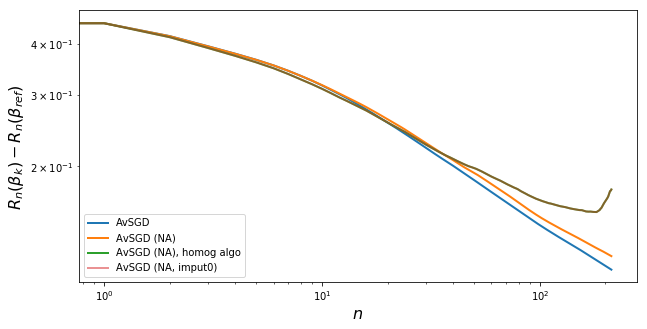

In [33]:
# Plotting - training -----------------------------------------
callbacks = [callback_av_sgd_comp, callback_av_sgd, callback_av_sgd_homog, callback_av_sgd_imput0] 
names = ["AvSGD", "AvSGD (NA)", "AvSGD (NA), homog algo", "AvSGD (NA, imput0)"] 


# Convergence in terms of excess risk ---
plt.figure(figsize=(10, 5))
alphas=[1,1,1,0.5]
for callback, name, alpha in zip(callbacks, names, alphas):
    objectives = callback.objectives -  model.loss(beta_ref)
    objectives_dist = np.array(callback.dist_it)
    plt.loglog(objectives, label=name, lw=2,alpha=alpha)


plt.xlabel(r'$n$',fontsize=16)
plt.ylabel(r"$R_n(\beta_k) - R_n(\beta_{ref})$", fontsize=16)
plt.legend(loc='lower left')

In [34]:
print('MSE with scikit linear predictor on train', "%.2e" % (np.linalg.norm((regScikit.predict(X_poly))-y)**2/n))
print('MSE with scikit ridge a=0.1      on train', "%.2e" % (np.linalg.norm((regScikitRidge.predict(X_poly))-y)**2/n))
print('MSE with beta_av_SGD             on train', "%.2e" % (np.linalg.norm(X_poly.dot(beta_av_sgd)-y)**2/n))

MSE with scikit linear predictor on train 9.63e-02
MSE with scikit ridge a=0.1      on train 9.79e-02
MSE with beta_av_SGD             on train 3.37e-01


#### On test

In [35]:
(regScikit.predict(X_test_poly))[:10],y_test[0:10]

(array([-0.71819706]), array([-0.63121092]))

In [36]:
# Plotting - test ------------------------

n_test = 10000
print('MSE with scikit linear predictor  on test', "%.2e" %
    (np.linalg.norm((regScikit.predict(X_test_poly)) - y_test)**2 / n_test))
print('MSE with scikit ridge a=0.001     on test',
      "%.2e" % (np.linalg.norm((regScikitRidge.predict(X_test_poly)) - y_test)**2 / n_test))
print('MSE with beta_av_SGD              on test',
      "%.2e" % (np.linalg.norm(X_test_poly.dot(beta_av_sgd_comp)-y_test)**2/n_test))
print('MSE with beta_av_SGD_NA           on test',
      "%.2e" % (np.linalg.norm(X_test_poly.dot(beta_av_sgd)-y_test)**2/n_test))
print('MSE with beta_av_SGD_homog        on test',
      "%.2e" % (np.linalg.norm(X_test_poly.dot(beta_av_sgd_homog)-y_test)**2/n_test))
print('MSE with beta_av_SGD_imput0       on test',
      "%.2e" % (np.linalg.norm(X_test_poly.dot(beta_av_sgd_imput0)-y_test)**2/n_test))


MSE with scikit linear predictor  on test 7.57e-07
MSE with scikit ridge a=0.001     on test 5.55e-07
MSE with beta_av_SGD              on test 3.59e-06
MSE with beta_av_SGD_NA           on test 2.65e-06
MSE with beta_av_SGD_homog        on test 9.45e-06
MSE with beta_av_SGD_imput0       on test 9.45e-06


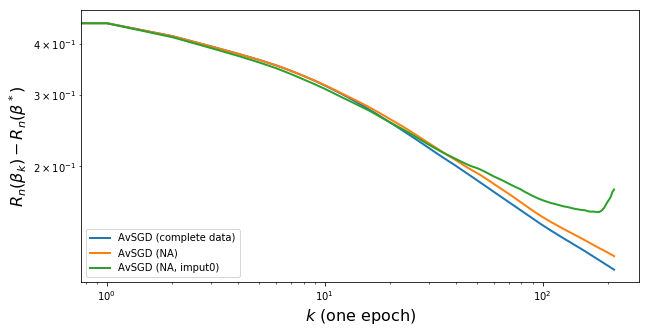

In [44]:
# Plotting - training -----------------------------------------
callbacks = [callback_av_sgd_comp, callback_av_sgd, callback_av_sgd_imput0] 
names = ["AvSGD (complete data)", "AvSGD (NA)", "AvSGD (NA, imput0)"] 


# Convergence in terms of excess risk ---
plt.figure(figsize=(10, 5))
alphas=[1,1,1,0.5]
for callback, name, alpha in zip(callbacks, names, alphas):
    objectives = callback.objectives -  model.loss(beta_ref)
    objectives_dist = np.array(callback.dist_it)
    plt.loglog(objectives, label=name, lw=2,alpha=alpha)


plt.xlabel(r'$k$ (one epoch)',fontsize=16)
plt.ylabel(r"$R_n(\beta_k) - R_n(\beta^*)$", fontsize=16)
plt.legend(loc='lower left')
plt.savefig('superconductivity_poly_features.pdf')